# The Leaf Classifier 🍃

This project builds a deep learning model to classify three types of tree leaves—Neem, Jujube, and Bougainvillea using a high-quality image dataset from Mendeley.

Leaf Species in the Dataset:
- **Neem:** Medicinal tree native to India, with pinnate leaves.
- **Jujube:** Small fruit-bearing tree, with shiny oval leaves.
- **Bougainvillea:** Flowering shrub or vine, with colorful bracts and green leaves.

A link to the dataset:  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/bgmftbm8zt-1.zip

### Intended Outcomes

**Accurate Leaf Classification**
The model should correctly identify each leaf as Neem, Jujube and Bougainvillea, demonstrating the ability to distinguish visually similar classes.

**End-to-End Production Workflow**
Gain hands-on experience in exporting a trained model (learn.export()) and loading it for inference (load_learner()).

**Interactive Prediction Interface**
Build a simple Gradio app that allows users to upload an image and get real-time predictions, showcasing a deployable ML workflow.

**Understanding of Model Challenges**
Learn how subtle visual differences affect predictions, data preparation, and model performance.

## Data Preparation

We have downloaded the dataset and stored them in a separate folder for each leaf type: Neem, Jujube and Bougainvillea.  Let's first ensure we can access the file path to the images and check the number of images.

In [2]:
from pathlib import Path
from fastai.vision.all import get_image_files

# Step 1: Set the base path to your dataset
base_path = Path('data/leaf')  # adjust if your folder name differs

# Step 2: Check if the folder exists
if not base_path.exists():
    print(f"ERROR: Folder {base_path} does not exist. Check the path!")
else:
    print(f"Folder {base_path} exists ✅")

    # Step 3: List subfolders (should be your classes)
    subfolders = [f for f in base_path.iterdir() if f.is_dir()]
    print("Found subfolders (classes):", [f.name for f in subfolders])

    # Step 4: Count images in each subfolder
    for folder in subfolders:
        images = get_image_files(folder)
        print(f"Class '{folder.name}': {len(images)} images")


/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <C62FA868-4C49-3B20-AFA6-2F7F59A295B4> /opt/anaconda3/envs/fastai_env/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Folder data/leaf exists ✅
Found subfolders (classes): ['neem leaf', 'Bougainvillea leaf', 'Jujube']
Class 'neem leaf': 45 images
Class 'Bougainvillea leaf': 161 images
Class 'Jujube': 128 images


We can see that we have a class imbalance: 'neem' leaf has far fewer images in comparison to the classes Bougainvillea and Jujube respectively.

### Convert files from HEIC to JPG/PNG

The first issue we need to deal with is that the images in our data folders are HEIC files (.heic).  PIL/FastAI can't open HEIC files by default, therefore we need to convert them to JPG/PNG format.

In [4]:
# Install pillow-heif if needed
# pip install pillow-heif

import pillow_heif         # Import the pillow-heif library to read HEIC image files
from pathlib import Path   # Import Path from pathlib to handle file system paths easily
from PIL import Image      # Import PIL's Image module to create and save images

# Define the path to the dataset folder containing leaf images
path = Path('data/leaf')

# Loop through all files in the folder and subfolders that end with '.heic'
for img_path in path.rglob('*.heic'):
    # Read the HEIC file into a pillow-heif object
    heif_file = pillow_heif.read_heif(str(img_path))

    # Convert the HEIC data into a standard PIL image   
    img = Image.frombytes(
        heif_file.mode,     # Colour mode e.g. 'RGB'
        heif_file.size,     # Width and height of the image
        heif_file.data,     # Raw image bytes
        "raw"
    )
    # Create a new path for the converted image with a '.jpg' extension
    new_path = img_path.with_suffix('.jpg')

    # Save the image as a JPG file in the same folder
    img.save(new_path)

    # Delete the original HEIC file (optional_
    img_path.unlink() 


Let's randomly inspect an image from each class.

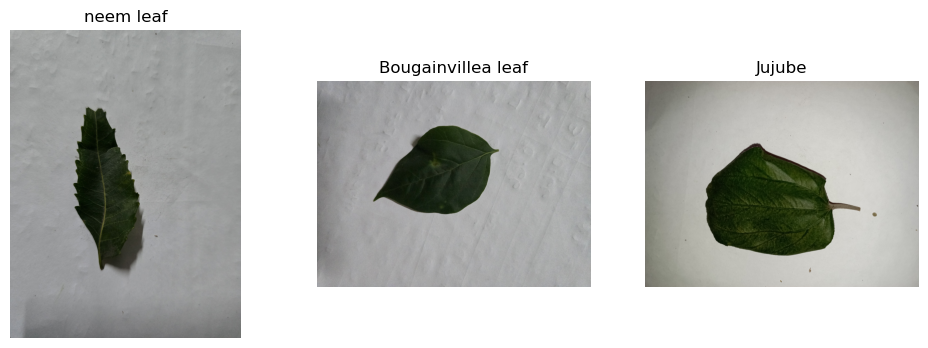

In [5]:
import random                           # Import the random module to pick random images
from fastai.vision.all import *         # Import FastAI vision utilities
from matplotlib import pyplot as plt    # Import matplotlib for plotting

# Define the path to your dataset folder containing the leaf images
path = Path('data/leaf')

# Create a list of subfolders in the dataset folder - each subfolder represents a leaf class
classes = [f for f in path.iterdir() if f.is_dir()]

# Set up a matplotlib figure with a specified size (width x height in inches)
plt.figure(figsize=(12,4))

# Loop over the classes and display one random image from each
for i, cls in enumerate(classes):
    # Get all image files in the current class folder
    images = get_image_files(cls)
    
    # Pick a random image from the class
    img_path = random.choice(images)
    
    # Open the image using PIL
    img = Image.open(img_path)

    # Create a subplot for this image in the figure, 1 row, len(classes) columns, postion i+1
    plt.subplot(1, len(classes), i+1)

    # Display the image
    plt.imshow(img)

    # Set the title of the subplot to the class name
    plt.title(cls.name)

    # Hide the axes (ticks) to keep the images clean
    plt.axis('off')

# Render and show the figure with all images
plt.show()


Now we want to check each class for corrupt images and remove them.  

In [6]:
# Define the root path of the dataset.  This folder contains one subfolder per class
path = Path('data/leaf')

# Create dictionary to store how many corrupt images are found per class
# Format:  {'class_name': number_of_corrupt_images}
corrupt_summary = {}

# Iterate through the contents of data/leaf
for cls in path.iterdir():

    # Skip anything that is not a directory
    if not cls.is_dir():
        continue

    # Create a counter for corrupt images in the class
    corrupt_count = 0

    # Get all image files inside the current class folder
    images = get_image_files(cls)

    # Loop through each image in the class
    for img_path in images:
        try:
            # Attempt to open the image using PIL
            with Image.open(img_path) as img:
                img.verify()  # verifies file integrity
        except Exception:
            # If any exception occurs, the image is considered corrupt
            corrupt_count += 1
            img_path.unlink()  # Delete the corrupt image

    # Store the total number of corrupt images found for the class
    corrupt_summary[cls.name] = corrupt_count

# Print summary of the cleaning process
print("Corrupt image removal summary:")
for cls, count in corrupt_summary.items():
    print(f"  {cls}: {count} corrupt images removed")


Corrupt image removal summary:
  neem leaf: 0 corrupt images removed
  Bougainvillea leaf: 0 corrupt images removed
  Jujube: 0 corrupt images removed
